# AutoEncoder Training
This notebook creates and trains an autoencoder on the MNIST dataset. It more or less does everything you need, and all you have to do is run the cells.

Might later add robustness to the autoencoder class depending on how this compression goes with the quantum learning. Hopefully that won't break this notebook. I'll try to update this notebook if it does.

In [14]:
import os
import time
import pickle
import torch
import torch.optim
import torch.nn as nn
import matplotlib.pyplot as plt
from torchsummary import summary
from MNISTData import MNISTData
from AutoEncoder import AutoEncoder

In [2]:
data = MNISTData()
train_loader = data.get_train_loader()
test_loader = data.get_test_loader()

In [3]:
autoencoder = AutoEncoder([256, 64, 10])

In [4]:
summary(autoencoder, input_size=(1, 28, 28))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Linear-1                  [-1, 256]         200,960
              ReLU-2                  [-1, 256]               0
            Linear-3                   [-1, 64]          16,448
              ReLU-4                   [-1, 64]               0
            Linear-5                   [-1, 10]             650
              ReLU-6                   [-1, 10]               0
            Linear-7                   [-1, 64]             704
              ReLU-8                   [-1, 64]               0
            Linear-9                  [-1, 256]          16,640
             ReLU-10                  [-1, 256]               0
           Linear-11                  [-1, 784]         201,488
          Sigmoid-12                  [-1, 784]               0
Total params: 436,890
Trainable params: 436,890
Non-trainable params: 0
-------------------------------

In [17]:
save_directory = "./autoencoder_models"
def save_model(model, model_name="ae.pt", message=None, fig_to_save=None):
    if not os.path.exists(save_directory):
        os.makedirs(save_directory)
    subdirectory_name = str(int(time.time()))
    subdirectory_path = os.path.join(save_directory, subdirectory_name)
    if not os.path.exists(subdirectory_path):
        os.makedirs(subdirectory_path)
    save_path = os.path.join(subdirectory_path, model_name)
    torch.save(model.state_dict(), save_path)
    layer_sizes_save_path = os.path.join(subdirectory_path, "layer_sizes.pkl")
    with open(layer_sizes_save_path, 'wb') as f:
        pickle.dump(model.layer_sizes, f)
    if message is not None:
        message_save_path = os.path.join(subdirectory_path, "message.txt")
        with open(message_save_path, 'w') as f:
            f.write(message + "\n")
    if fig_to_save is not None:
        fig_save_path = os.path.join(subdirectory_path, "generated_examples.png")
        fig_to_save.savefig(fig_save_path)
    print("everything was saved to %s" % subdirectory_path)

In [6]:
distance = nn.MSELoss()
optimizer = torch.optim.Adam(autoencoder.parameters(), lr=1e-3, weight_decay=1e-5)

In [7]:
num_epochs = 100
start = time.time()
for epoch in range(num_epochs):
    running_loss = 0.0
    for i, data in enumerate(train_loader):
        img, _ = data
        
        output = autoencoder(img)
        loss = distance(output, img)
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
        if i % 200 == 199:
            print('[%d, %5d] loss: %.3f' %
                  (epoch + 1, i + 1, running_loss / 200))
            running_loss = 0.0
        
    # ===================log========================
    print('epoch [{}/{}], loss:{:.4f}'.format(epoch+1, num_epochs, loss.item()))
    if epoch % 10 == 9:
        print('it took %d seconds for %d epochs' % (time.time() - start, num_epochs))
print('it took %d seconds to finish %d epochs' % (time.time() - start, num_epochs))

[1,   200] loss: 0.264
[1,   400] loss: 0.231
epoch [1/100], loss:0.2317
[2,   200] loss: 0.231
[2,   400] loss: 0.231
epoch [2/100], loss:0.2316
[3,   200] loss: 0.231
[3,   400] loss: 0.231
epoch [3/100], loss:0.2314
[4,   200] loss: 0.231
[4,   400] loss: 0.231
epoch [4/100], loss:0.2315
[5,   200] loss: 0.231
[5,   400] loss: 0.231
epoch [5/100], loss:0.2302
[6,   200] loss: 0.231
[6,   400] loss: 0.231
epoch [6/100], loss:0.2307
[7,   200] loss: 0.230
[7,   400] loss: 0.230
epoch [7/100], loss:0.2283
[8,   200] loss: 0.230
[8,   400] loss: 0.230
epoch [8/100], loss:0.2297
[9,   200] loss: 0.230
[9,   400] loss: 0.230
epoch [9/100], loss:0.2305
[10,   200] loss: 0.229
[10,   400] loss: 0.228
epoch [10/100], loss:0.2276
it took 238 seconds for 100 epochs
[11,   200] loss: 0.227
[11,   400] loss: 0.227
epoch [11/100], loss:0.2276
[12,   200] loss: 0.227
[12,   400] loss: 0.227
epoch [12/100], loss:0.2280
[13,   200] loss: 0.227
[13,   400] loss: 0.226
epoch [13/100], loss:0.2249
[14,

In [9]:
examples = enumerate(test_loader)
batch_idx, (example_data, example_targets) = next(examples)
with torch.no_grad():
    outputs = autoencoder(example_data)
    print(distance(example_data, outputs).item())

0.2226255089044571


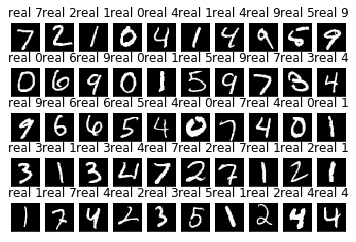

In [10]:
fig = plt.figure()
for i in range(50):
    plt.subplot(5, 10, i+1)
    plt.imshow(example_data[i][0], cmap='gray', interpolation='none')
    plt.title("real %d" % example_targets[i])
    plt.xticks([])
    plt.yticks([])

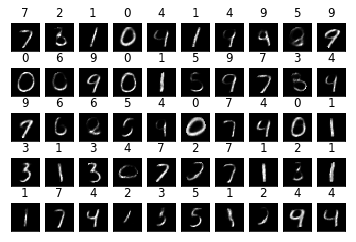

In [11]:
fig = plt.figure()
for i in range(50):
    plt.subplot(5, 10, i + 1)
    plt.imshow(outputs[i][0], cmap='gray', interpolation='none')
    plt.title("%d" % example_targets[i])
    plt.xticks([])
    plt.yticks([])

In [12]:
# if you would like to write some notes, save it as a string and pass it to the 'message' parameter of save_model
# if you don't set message to None
message = '''This model only uses an encoding size of 10. does not to too poorly, but we will put in
an EncoderClassifier and see how it does.'''

In [18]:
save_model(autoencoder, message=message, fig_to_save=fig)

everything was saved to ./autoencoder_models/1558731906
